In [2]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load the training dataset
train_data = pd.read_csv('/content/drive/MyDrive/Leakage Detection/leakage_dataset_train_1000.csv')
X_train = train_data.drop(['y1', 'y2'], axis=1).values
Y_train = train_data[['y1', 'y2']].values

# Adjust x4 values to correct for the malfunction
X_train[:, 3] = X_train[:, 3] - np.mean(X_train[:, :3], axis=1)

# Load the validation dataset
val_data = pd.read_csv('/content/drive/MyDrive/Leakage Detection/leakage_dataset_validation_1000.csv')
X_val = val_data.drop(['y1', 'y2'], axis=1).values
Y_val = val_data[['y1', 'y2']].values

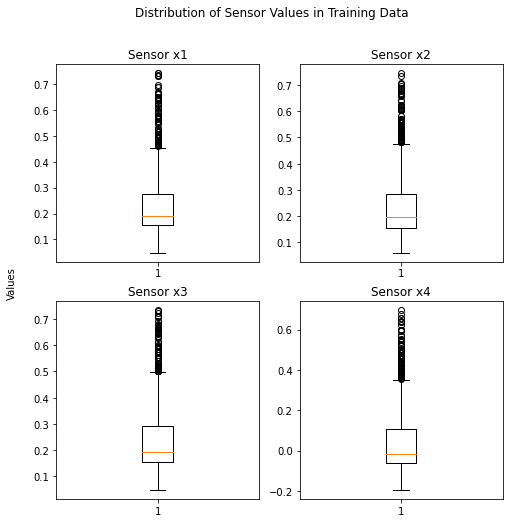

In [10]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Create box plots for each sensor
axs[0, 0].boxplot(X_train[:, 0])
axs[0, 0].set_title('Sensor x1')
axs[0, 1].boxplot(X_train[:, 1])
axs[0, 1].set_title('Sensor x2')
axs[1, 0].boxplot(X_train[:, 2])
axs[1, 0].set_title('Sensor x3')
axs[1, 1].boxplot(X_train[:, 3])
axs[1, 1].set_title('Sensor x4')

# Set y-axis label
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')

# Set title of the figure
fig.suptitle('Distribution of Sensor Values in Training Data')

# Show the plot
plt.show()

In [11]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.001
depth = 2
width = 32

# Build the model
model = Sequential()
model.add(Dense(width, input_dim=X_train.shape[1], activation='relu'))
for i in range(depth - 1):
    model.add(Dense(width, activation='relu'))
model.add(Dense(2, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

# Save the model
model.save('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_0.h5')

Epoch 1/100
32/32 [==============================] - 1s 11ms/step - loss: 0.3363 - accuracy: 0.7580 - val_loss: 0.3482 - val_accuracy: 0.7220
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1641 - accuracy: 0.8430 - val_loss: 0.3018 - val_accuracy: 0.8090
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0921 - accuracy: 0.9240 - val_loss: 0.3634 - val_accuracy: 0.8830
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0754 - accuracy: 0.9430 - val_loss: 0.3498 - val_accuracy: 0.8660
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0670 - accuracy: 0.9480 - val_loss: 0.3608 - val_accuracy: 0.8700
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.9420 - val_loss: 0.3724 - val_accuracy: 0.8660
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0626 - accuracy: 0.9410 - val_loss: 0.3346 - val_accuracy: 0.8680
Epoch 8/100


In [14]:
from keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_0.h5')

# Make predictions on new data
X_new = [[1.51622149e+00, -5.42255062e-01, -6.40267721e-01,
        -2.32916509e-01]]
predictions = model.predict(X_new)


y1_predictions = predictions[:,0]
y2_predictions = predictions[:,1]


1/1 [==============================] - 0s 79ms/step


In [15]:
y1_predictions, y2_predictions
#Actual values [-0.71571846,  0.31258276]

(array([-0.67262894], dtype=float32), array([0.33399275], dtype=float32))

Hyperparameter Tuning

In [16]:
import kerastuner as kt

# Define the search space for the hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('width', min_value=32, max_value=512, step=32), input_dim=X_train.shape[1], activation='relu'))
    for i in range(hp.Int('depth', 1, 5) - 1):
        model.add(Dense(hp.Int('width', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(2, activation='linear'))
    model.compile(loss='mean_absolute_error',metrics=['accuracy'],optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model

# Create a tuner
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=100, factor=3, directory='my_dir', project_name='my_project')

# Search for the best hyperparameters
tuner.search(X_train, Y_train, validation_data=(X_val, Y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_1.h5')


Trial 254 Complete [00h 00m 23s]
val_loss: 0.2464475929737091

Best val_loss So Far: 0.17419447004795074
Total elapsed time: 00h 25m 03s


In [18]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_1.h5')

# Make predictions on new data
X_new = [[9.81493155e-01, -3.10622537e-01, -3.61754939e-01,
        -2.30459658e-01]]
predictions = model.predict(X_new)

y1_predictions = predictions[:,0]
y2_predictions = predictions[:,1]

1/1 [==============================] - 0s 126ms/step


In [19]:
y1_predictions, y2_predictions
#Actual values  [-0.40606274,  0.29526814]

(array([-0.3299892], dtype=float32), array([0.43579534], dtype=float32))

Augment the dataset. Each training example (x,y) can be comple- mented by seven additional virtual examples as illustrated in Figure 1. Clockwise rotations and flips on input data x are obtained as described above. A clockwise rotation on output data y is obtained through y90 = (y2,−y1) and a flip along the vertical axis on the same data is represented by yflipped = (−y1,y2). All other operations (rotation an- gles and associated flips) can be computed by subsequent application of these two operations.


In [22]:

def augment_data(X_train, Y_train):
    # 90 degree rotation
    X_train_rotated_90 = np.rot90(X_train, k=1, axes=(1,0))
    Y_train_rotated_90 = np.fliplr(Y_train) * np.array([-1, 1])
    print(X_train_rotated_90.shape,Y_train_rotated_90.shape)

    # 180 degree rotation
    X_train_rotated_180 = np.rot90(X_train, k=2, axes=(1,0))
    Y_train_rotated_180 = Y_train * np.array([-1, -1])
    print(X_train_rotated_180.shape,Y_train_rotated_180.shape)


    # 270 degree rotation
    X_train_rotated_270 = np.rot90(X_train, k=3, axes=(1,0))
    Y_train_rotated_270 = np.fliplr(Y_train) * np.array([1, -1])
    print(X_train_rotated_270.shape,Y_train_rotated_270.shape)

    # flip
    X_train_flipped = np.fliplr(X_train)
    Y_train_flipped = Y_train * np.array([-1, 1])    
    print(X_train_flipped.shape,Y_train_flipped.shape)

    
    # 90 degree rotation and flip
    X_train_rotated_90_flipped = np.rot90(X_train_flipped, k=1, axes=(1,0))
    Y_train_rotated_90_flipped = np.fliplr(Y_train_flipped) * np.array([-1, 1])
    print(X_train_rotated_90_flipped.shape,Y_train_rotated_90_flipped.shape)

    # 180 degree rotation and flip
    X_train_rotated_180_flipped = np.rot90(X_train_flipped, k=2, axes=(1,0))
    Y_train_rotated_180_flipped = Y_train_flipped * np.array([-1, -1])
    print(X_train_rotated_180_flipped.shape,Y_train_rotated_180_flipped.shape)

    # 270 degree rotation and flip
    X_train_rotated_270_flipped = np.rot90(X_train_flipped, k=3, axes=(1,0))
    Y_train_rotated_270_flipped = np.fliplr(Y_train_flipped) * np.array([1, -1])
    print(X_train_rotated_270_flipped.shape,Y_train_rotated_270_flipped.shape)


    X_augmented = np.concatenate((X_train, X_train_rotated_90.reshape(1000,4), X_train_rotated_180, X_train_rotated_270.reshape(1000,4), X_train_flipped,
                                  X_train_rotated_90_flipped.reshape(1000,4), X_train_rotated_180_flipped, X_train_rotated_270_flipped.reshape(1000,4)), axis=0)
    Y_augmented = np.concatenate((Y_train, Y_train_rotated_90, Y_train_rotated_180, Y_train_rotated_270, Y_train_flipped,
                                  Y_train_rotated_90_flipped, Y_train_rotated_180_flipped, Y_train_rotated_270_flipped), axis=0)
    return X_augmented, Y_augmented


In [23]:
X_train_augmented, Y_train_augmented = augment_data(X_train, Y_train)

(4, 1000) (1000, 2)
(1000, 4) (1000, 2)
(4, 1000) (1000, 2)
(1000, 4) (1000, 2)
(4, 1000) (1000, 2)
(1000, 4) (1000, 2)
(4, 1000) (1000, 2)


In [24]:

# Define the search space for the hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('width', min_value=32, max_value=512, step=32), input_dim=X_train.shape[1], activation='relu'))
    for i in range(hp.Int('depth', 1, 5) - 1):
        model.add(Dense(hp.Int('width', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(2, activation='linear'))
    model.compile(loss='mean_absolute_error',metrics = ['accuracy'], optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    return model

# Create a tuner
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=100, factor=3, directory='my_dir_2', project_name='my_project')

# Search for the best hyperparameters
tuner.search(X_train_augmented, Y_train_augmented, validation_data=(X_val, Y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_2.h5')


Trial 254 Complete [00h 01m 23s]
val_loss: 0.43796664476394653

Best val_loss So Far: 0.2976060211658478
Total elapsed time: 01h 24m 16s


In [27]:
# Load the trained model
model = load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_2.h5')

# Make predictions on new data
X_new = [[9.81493155e-01, -3.10622537e-01, -3.61754939e-01,
        -2.30459658e-01]]
predictions = model.predict(X_new)
y1_predictions = predictions[:,0]
y2_predictions = predictions[:,1]

1/1 [==============================] - 0s 134ms/step


In [28]:
y1_predictions, y2_predictions
#Actual values  [-0.40606274,  0.29526814]

(array([-0.03584344], dtype=float32), array([-0.02380597], dtype=float32))

In [32]:
class EquivariantHiddenLayer(keras.layers.Layer):
  def _init_(self,name =None,**kwargs):
    super(EquivariantHiddenLayer, self)._init_(**kwargs)
    
  def build(self, input_shape):
    initializer = tf.keras.initializers.RandomNormal(stddev=0.2)
    self.a = self.add_weight(name='w1',shape = (), initializer = initializer, trainable = True)
    self.b = self.add_weight(name='w2',shape = (), initializer = initializer, trainable = True)
    self.c = self.add_weight(name='w3',shape = (), initializer = initializer, trainable = True)

  def call(self, inputs):
    W1 = [[self.a, self.b, self.c, self.b],
          [self.b, self.a, self.b, self.c],
          [self.c, self.b, self.a, self.b],
          [self.b, self.c, self.b, self.a]]
    return tf.matmul(inputs, W1)
	
 
class EquivariantOutputLayer(keras.layers.Layer):
  def _init_(self, **kwargs):
    super(EquivariantOutputLayer, self)._init_(**kwargs)

  def build(self, input_shape):
    initializer = tf.keras.initializers.RandomNormal(stddev=0.2)
    self.d = self.add_weight(name = "o1", shape = (), initializer = initializer, trainable = True)
        
  def call(self, inputs):
    first_term = self.d * tf.reduce_sum(inputs * [1, -1, -1, 1], axis=1, keepdims=True)
    second_term = self.d * tf.reduce_sum(inputs * [-1, -1, 1, 1], axis=1, keepdims=True)
    return tf.concat([first_term, second_term], axis=1)

In [33]:
# Define the hyperparameters
epochs = 50
batch_size = 32
learning_rate = 0.01
depth = 2
width = 32
 
#Defining the Model 
model_equivariant_100 = tf.keras.Sequential()
model_equivariant_100.add(EquivariantHiddenLayer())
model_equivariant_100.add(EquivariantOutputLayer())
model_equivariant_100.compile(optimizer = Adam(0.01), loss='mean_absolute_error', metrics = ["accuracy"])
# Train the model
history = model_equivariant_100.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

# Save the model
model.save('/content/drive/MyDrive/Leakage Detection/Final_models/model_equivariant_3.h5')

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


32/32 [==============================] - 2s 14ms/step - loss: 0.3745 - accuracy: 0.9270 - val_loss: 0.2629 - val_accuracy: 0.9490
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.1251 - accuracy: 0.9440 - val_loss: 0.2531 - val_accuracy: 0.9490
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.1125 - accuracy: 0.9440 - val_loss: 0.2643 - val_accuracy: 0.9490
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.1131 - accuracy: 0.9440 - val_loss: 0.2650 - val_accuracy: 0.9490
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.9440 - val_loss: 0.2589 - val_accuracy: 0.9490
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.1125 - accuracy: 0.9440 - val_loss: 0.2581 - val_accuracy: 0.9490
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.1117 - accuracy: 0.9440 - val_loss: 0.2569 - val_accuracy: 0.9490
Epoch 8/50
32/32 [============

In [34]:
# Training the model for Augmented Dataset
history = model_equivariant_100.fit(X_train_augmented, Y_train_augmented, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

# Save the model
model.save('/content/drive/MyDrive/Leakage Detection/Final_models/model_equivariant_4_augmented.h5')

Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.5091 - accuracy: 0.5067 - val_loss: 0.4882 - val_accuracy: 0.9490
Epoch 2/50
250/250 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4905 - val_accuracy: 0.9490
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4922 - val_accuracy: 0.9490
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4958 - val_accuracy: 0.9490
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4976 - val_accuracy: 0.9490
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4986 - val_accuracy: 0.9490
Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.5052 - accuracy: 0.5067 - val_loss: 0.4988 - val_accuracy: 0.9490
Epoch 

1/1 [==============================] - 0s 87ms/step


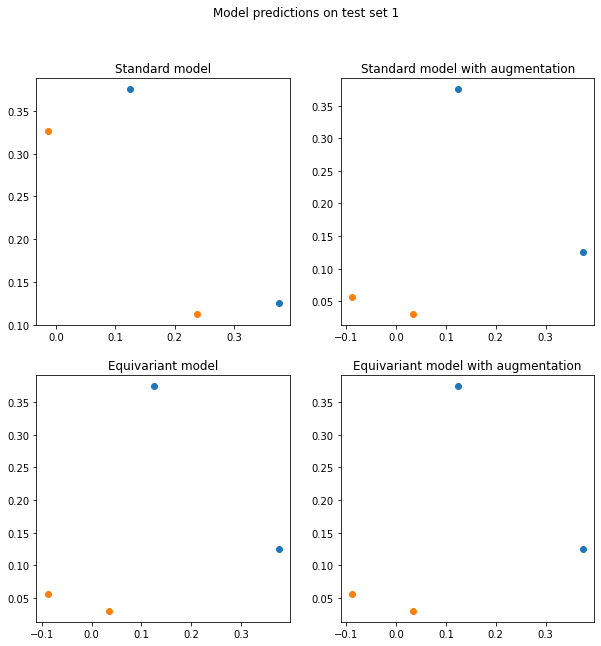

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define the test sets
test_set_1 = np.array([[0.125, 0.25, 0.375, 0.25], [0.375, 0.25, 0.125, 0.25]])
test_set_2 = np.array([[0.25, 0.125, 0.25, 0.375], [0.25, 0.375, 0.25, 0.125]])

# Load the models
model_standard = keras.models.load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_1.h5')
model_standard_aug = keras.models.load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_standard_2.h5')

# load the saved weights
model_equivariant = keras.models.load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_equivariant_3.h5')
model_equivariant_aug = keras.models.load_model('/content/drive/MyDrive/Leakage Detection/Final_models/model_equivariant_4_augmented.h5')



#model_equivariant_aug.load_weights('/content/drive/MyDrive/Leakage Detection/model_equivariant_4_augmented.h5')

# Make predictions on the test sets
pred_standard = model_standard.predict(test_set_1)
pred_standard_aug = model_standard_aug.predict(test_set_1)
pred_equivariant = model_equivariant.predict(test_set_1)
pred_equivariant_aug = model_equivariant_aug.predict(test_set_1)

# Plot the predictions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Model predictions on test set 1')
axs[0, 0].scatter(test_set_1[:, 0], test_set_1[:, 2])
axs[0, 0].scatter(pred_standard[:, 0], pred_standard[:, 1])
axs[0, 0].set_title('Standard model')
axs[0, 1].scatter(test_set_1[:, 0], test_set_1[:, 2])
axs[0, 1].scatter(pred_standard_aug[:, 0], pred_standard_aug[:, 1])
axs[0, 1].set_title('Standard model with augmentation')
axs[1, 0].scatter(test_set_1[:, 0], test_set_1[:, 2])
axs[1, 0].scatter(pred_equivariant[:, 0], pred_equivariant[:, 1])
axs[1, 0].set_title('Equivariant model')
axs[1, 1].scatter(test_set_1[:, 0], test_set_1[:, 2])
axs[1, 1].scatter(pred_equivariant_aug[:, 0], pred_equivariant_aug[:, 1])
axs[1, 1].set_title('Equivariant model with augmentation')
plt.show()
